In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, rfft, rfftfreq
import numpy as np

from matplotlib import mlab

from tqdm.auto import tqdm
from scipy.ndimage.morphology import (generate_binary_structure,
                                      iterate_structure, binary_erosion)
from scipy.ndimage.filters import maximum_filter
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from operator import itemgetter
import hashlib

In [2]:

IDX_FREQ_I = 0
IDX_TIME_J = 1

######################################################################
# Sampling rate, related to the Nyquist conditions, which affects
# the range frequencies we can detect.
DEFAULT_FS = 44100

######################################################################
# Size of the FFT window, affects frequency granularity
DEFAULT_WINDOW_SIZE = 4096

######################################################################
# Ratio by which each sequential window overlaps the last and the
# next window. Higher overlap will allow a higher granularity of offset
# matching, but potentially more fingerprints.
DEFAULT_OVERLAP_RATIO = 0.5

######################################################################
# Degree to which a fingerprint can be paired with its neighbors --
# higher will cause more fingerprints, but potentially better accuracy.
DEFAULT_FAN_VALUE = 15

######################################################################
# Minimum amplitude in spectrogram in order to be considered a peak.
# This can be raised to reduce number of fingerprints, but can negatively
# affect accuracy.
DEFAULT_AMP_MIN = 10

######################################################################
# Number of cells around an amplitude peak in the spectrogram in order
# for Dejavu to consider it a spectral peak. Higher values mean less
# fingerprints and faster matching, but can potentially affect accuracy.
PEAK_NEIGHBORHOOD_SIZE = 20

######################################################################
# Thresholds on how close or far fingerprints can be in time in order
# to be paired as a fingerprint. If your max is too low, higher values of
# DEFAULT_FAN_VALUE may not perform as expected.
MIN_HASH_TIME_DELTA = 0
MAX_HASH_TIME_DELTA = 200

######################################################################
# If True, will sort peaks temporally for fingerprinting;
# not sorting will cut down number of fingerprints, but potentially
# affect performance.
PEAK_SORT = True

######################################################################
# Number of bits to grab from the front of the SHA1 hash in the
# fingerprint calculation. The more you grab, the more memory storage, 
# with potentially lesser collisions of matches.
FINGERPRINT_REDUCTION = 20

In [244]:
def spectrogram(data, plot=False):
    specgram = mlab.specgram(data,  
         NFFT=DEFAULT_WINDOW_SIZE,
         Fs=DEFAULT_FS,
         window=mlab.window_hanning,
         noverlap=int(DEFAULT_WINDOW_SIZE * DEFAULT_OVERLAP_RATIO))[0]
    specgram = 10 * np.log10(specgram)
    specgram = specgram[50:500, :]
    specgram[specgram == -np.inf] = 0
    if plot:
        plt.imshow(specgram.T, vmin=-100, vmax=100)
    else:
        return specgram

In [255]:
def get_2D_peaks(arr2D, plot=False, amp_min=DEFAULT_AMP_MIN):
    #  http://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.iterate_structure.html#scipy.ndimage.iterate_structure
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, PEAK_NEIGHBORHOOD_SIZE)

    # find local maxima using our filter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                       border_value=1)

    # Boolean mask of arr2D with True at peaks (Fixed deprecated boolean operator by changing '-' to '^')
    detected_peaks = local_max ^ eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = filter(lambda x: x[2]>amp_min, peaks) # freq, time, amp
    # get indices for frequency and time
    frequency_idx = []
    time_idx = []
    for x in peaks_filtered:
        frequency_idx.append(x[1])
        time_idx.append(x[0])
    
    if plot:
        # scatter of the peaks
        fig, ax = plt.subplots()
        ax.imshow(arr2D.T)
        ax.scatter(frequency_idx, time_idx)
        ax.set_ylabel('Time')
        ax.set_xlabel('Frequency')
        ax.set_xlim(0, 500-50)
        ax.set_title("Spectrogram")
        ax.invert_yaxis()
        fig.set_size_inches(10, 10)
        plt.show()

    peaks = list(zip(frequency_idx, time_idx))
    if PEAK_SORT:
        peaks.sort(key=itemgetter(1))
    return peaks


In [4]:
def random_fragment(data, length=5):
    max_start=int(len(data) / rate) - length - 5

    true_start = np.random.randint(0, max_start)
    true_stop=true_start+length
    data_true=data[(true_start*rate):(true_stop*rate)]
    return data_true, true_start, true_stop


In [5]:
def get_fragment(data, start, stop):
    return data[int(start*rate):int(stop*rate)] 

In [5]:
!ffmpeg -i pod1.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod1.wav

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [6]:
!ffmpeg -i pod2.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod2.wav

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [7]:
!ffmpeg -i pod3.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod3.wav

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [141]:
stations = [
    wav.read('pod1.wav')[1],
    wav.read('pod2.wav')[1],
    wav.read('pod3.wav')[1],
]
rate = 44100

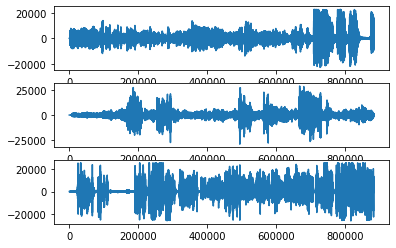

In [33]:
fig, axs=plt.subplots(nrows=len(stations))
for ax, station in zip(axs, stations):
    ax.plot(get_fragment(station, 0, 20))
#     ax.set_ylim(-1000, 1000)

In [10]:
!ffmpeg -i pod1-3.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod1-3.wav
!ffmpeg -i pod2-1.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod2-1.wav
!ffmpeg -i pod3-2.mp3 -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav pod3-2.wav

ffmpeg version 2.8.15-0ubuntu0.16.04.1 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --

In [11]:
queries = [
    wav.read('pod1-3.wav')[1],
    wav.read('pod2-1.wav')[1],
    wav.read('pod3-2.wav')[1],
]

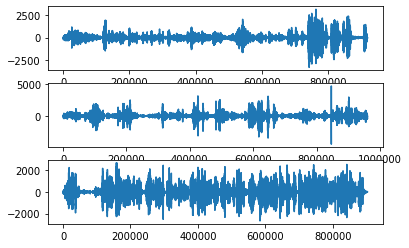

In [12]:
fig, axs=plt.subplots(nrows=len(stations))
for ax, station in zip(axs, queries):
    ax.plot(station)
#     ax.set_ylim(-1000, 1000)

In [15]:
import pydub

In [23]:
[
    pydub.audio_segment.AudioSegment.from_wav('pod%d.wav' % i).dBFS for i in [1, 2, 3]
]

[-24.49495383343727, -22.367587700006183, -20.900788879675744]

In [25]:
[
    pydub.audio_segment.AudioSegment.from_wav('pod1-3.wav').dBFS,
    pydub.audio_segment.AudioSegment.from_wav('pod2-1.wav').dBFS,
    pydub.audio_segment.AudioSegment.from_wav('pod3-2.wav').dBFS,
]

[-42.81403177899228, -43.50011640239199, -39.78221315139747]

In [ ]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [30]:
for wav_file in ['pod1-3.wav', 'pod2-1.wav', 'pod3-2.wav']:
#     pass
    segment = pydub.audio_segment.AudioSegment.from_wav(wav_file)
    segment_normalized = match_target_amplitude(segment, -23)
    segment_normalized.export(wav_file.replace('.wav', '.normalized.wav'), format='wav')

In [31]:
queries = [
    wav.read('pod1-3.normalized.wav')[1],
    wav.read('pod2-1.normalized.wav')[1],
    wav.read('pod3-2.normalized.wav')[1],
]

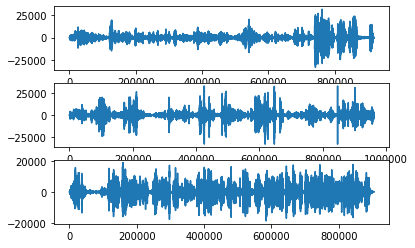

In [32]:
fig, axs=plt.subplots(nrows=len(stations))
for ax, station in zip(axs, queries):
    ax.plot(station)
#     ax.set_ylim(-1000, 1000)

In [220]:
amp_min = 1

In [311]:
def calculate_cost_2(reference_peaks, query_peaks_offset, match_threshold=5):
#     print(len(reference_peaks), len(query_peaks_offset))
    dist = cdist(reference_peaks, query_peaks_offset)
#     print(dist.shape)
#     raise Exception()
    ref_match, query_match = linear_sum_assignment(dist)
#     print(dist[ref_match, query_match].shape)
#     print(match_threshold)
#     raise Exception()
    total_count = (dist[ref_match, query_match] <= match_threshold).sum()
#     print(total_count)
#     raise Exception()
    return total_count

In [376]:
def calculate_cost_3(reference_peaks, query_peaks_offset, match_threshold=(10, 20)):
    max_freq_diff, max_time_diff = match_threshold
    total = 0
    q_mask = np.ones(len(query_peaks), dtype=bool)
    double_break = False
    for ref_peak in reference_peaks:
#         print(ref_peak)
        for i_q, q_peak in enumerate(query_peaks_offset):
            if q_mask[i_q] == False or abs(ref_peak[1] - q_peak[1]) > max_time_diff:
                continue
#             print(i_q)
            if abs(ref_peak[0] - q_peak[0]) < max_freq_diff:
                total += 1
#                 print('yo')
                q_mask[i_q] = False
                double_break = True
                break
        if double_break:
            continue
    return total

In [381]:
def match_offset(reference_peaks, query_peaks, offset_max=25, offset_step=3, match_threshold=(10, 20)):
    query_peaks = np.array(query_peaks)
    reference_peaks = np.array(reference_peaks)
    
    max_total_cost = 0
    for offset in range(-offset_max, offset_max, offset_step):
        query_peaks_offset = np.copy(query_peaks)
        query_peaks_offset[:, 1] = query_peaks_offset[:, 1] + offset
        cost = calculate_cost_3(reference_peaks, query_peaks_offset, match_threshold=match_threshold)
        if cost > max_total_cost:
            max_total_cost = cost
    return max_total_cost
    
    

In [378]:
def peaks_offset_match_distance(reference, query, offset_max=30, offset_step=3, match_threshold=(10, 20)):
    reference_peaks = get_2D_peaks(spectrogram(reference), plot=False, amp_min=amp_min)
    query_peaks = get_2D_peaks(spectrogram(query), plot=False, amp_min=amp_min)
    return match_offset(reference_peaks, query_peaks, offset_max=offset_max, offset_step=offset_step, match_threshold=match_threshold)

In [379]:
def peaks_offset_match_distance_precomputed(reference_peaks, query_peaks, offset_max=30, offset_step=3, match_threshold=(10, 20)):
    return match_offset(reference_peaks, 
                        query_peaks, 
                        offset_max=offset_max, 
                        offset_step=offset_step, match_threshold=match_threshold)

In [38]:
[len(s)/rate for s in stations]

[1831.810612244898, 2028.9567346938775, 1882.8016326530612]

In [394]:
amp_min = 25

In [561]:
stations_short = [
    stat[:(120*rate)]
    for stat in stations
]

station_frags = [
    [get_fragment(s, start, start+5) for start in range(0, int(len(s)/rate - 5), 1)] for s in stations_short
]

station_frags_starts = [
    [start for start in  range(0, int(len(s)/rate - 5))] for s in stations
]


# def match_station(stations, query, descriptor):
    

In [562]:
for i, s in enumerate(stations_short):
    wav.write('pod.%d.short.wav' % (i+1), rate, s)

In [563]:
# import pickle
# with open('peaks.3.full.pkl', 'wb') as f:
#     pickle.dump(station_peaks, f, -1)

In [564]:
station_peaks = [
    [get_2D_peaks(spectrogram(frag), plot=False, amp_min=amp_min) 
     for frag in tqdm(stat_frags)] for stat_frags in station_frags
]

In [596]:
for s in station_peaks:
    print(len(s))
    print(np.mean([len(ss) for ss in s]))

115
32.495652173913044
115
34.69565217391305
115
36.56521739130435


In [603]:
true_station = np.random.randint(3)

In [682]:
true_station=2

In [683]:
query, qstart, qend = random_fragment(queries[true_station])

In [684]:
qstart, qend

(6, 11)

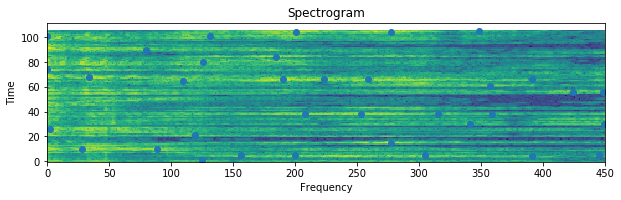

In [685]:
query_peaks = get_2D_peaks(spectrogram(query), plot=True, amp_min=amp_min)

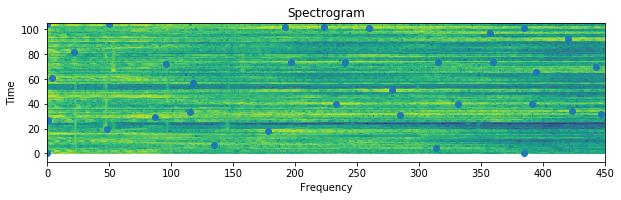

In [686]:
ref_peaks = get_2D_peaks(spectrogram(get_fragment(stations[true_station], qstart, qend)), plot=True, amp_min=amp_min)

In [687]:
# calculate_cost_3(ref_peaks, query_peaks)

In [688]:
peaks_offset_match_distance_precomputed(ref_peaks, 
                                        query_peaks, 
                                        offset_max=24, 
                                        offset_step=2, 
                                        match_threshold=(20, 5))

10

In [689]:
# %prun peaks_offset_match_distance_precomputed(ref_peaks, query_peaks, offset_max=24, offset_step=4, match_threshold=(15, 5))

In [690]:
station_match = [
    [peaks_offset_match_distance_precomputed(ref_peaks, 
                                             query_peaks, 
                                             offset_max=24, 
                                             offset_step=2, 
                                             match_threshold=(10, 5))
     for ref_peaks in tqdm(s)] for s in station_peaks
]

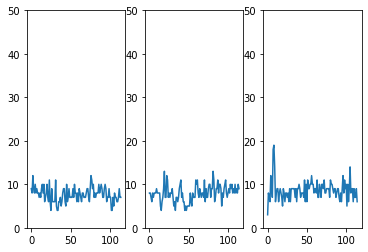

In [691]:
fig, axs = plt.subplots(ncols=3)
for m, ax in zip(station_match, axs):
    ax.plot(m)
#     ax.
    ax.set_ylim(0, 50)
    

In [692]:
station_best_match = [max(m) for m in station_match]

In [693]:
best_station = np.argmax(station_best_match)

In [694]:
best_station, station_best_match[best_station]

(2, 19)

In [695]:
true_station

2

In [482]:
best_frag_idx = np.argmax(station_match[best_station])

In [488]:
# frag = get_fragment(data_tok, best_frag_idx, best_frag_idx+5)



# wav.write('frag.found.wav', rate, frag)
# wav.write('frag.query.wav', rate, frag)

# peaks_offset_match_distance(frag, query)